In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
!mkdir dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Get the dataset
!unzip /content/drive/MyDrive/temp/balanced_dataset.zip -d /content/dataset

Archive:  /content/drive/MyDrive/temp/balanced_dataset.zip
  inflating: /content/dataset/Normal/Normal (1868).jpg  
  inflating: /content/dataset/Normal/Normal (1044).jpg  
  inflating: /content/dataset/Normal/Normal (3183).jpg  
  inflating: /content/dataset/Normal/Normal (3120).jpg  
  inflating: /content/dataset/Normal/Normal (278).jpg  
  inflating: /content/dataset/Normal/Normal (1916).jpg  
  inflating: /content/dataset/Normal/Normal (2189).jpg  
  inflating: /content/dataset/Normal/Normal (2903).jpg  
  inflating: /content/dataset/Normal/Normal (1981).jpg  
  inflating: /content/dataset/Normal/Normal (469).jpg  
  inflating: /content/dataset/Normal/Normal (2505).jpg  
  inflating: /content/dataset/Normal/Normal (2586).jpg  
  inflating: /content/dataset/Normal/Normal (1357).jpg  
  inflating: /content/dataset/Normal/Normal (2561).jpg  
  inflating: /content/dataset/Normal/Normal (400).jpg  
  inflating: /content/dataset/Normal/Normal (197).jpg  
  inflating: /content/dataset/Nor

In [5]:
#Load the model here
from keras.models import load_model
model = load_model('/content/drive/MyDrive/FinalUnet.h5',compile=False)

Preprocessed image shape: (1, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


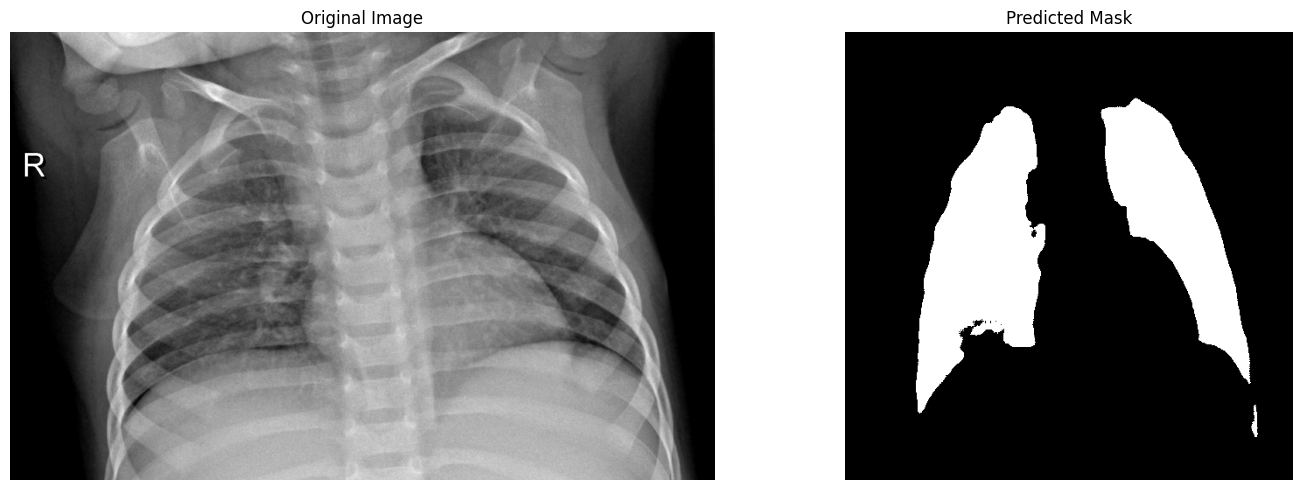

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, image_size=(512, 512)):
    # Load the grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    # Resize the image to match model input and normalize
    img_resized = cv2.resize(img, image_size) / 255.0
    img_resized = np.stack([img_resized] * 3, axis=-1)  # Expand to 3 channels
    return img, img_resized  # Return original and resized images

# Image path
image_path = "/content/dataset/Normal/Normal (1010).jpg"

# Load and preprocess the image
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for model prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)
print(f"Preprocessed image shape: {preprocessed_image_batch.shape}")

# Make prediction
predicted_mask = model.predict(preprocessed_image_batch)

# Ensure the predicted mask is binary
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Plot Original Image and Predicted Mask
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [18]:
def load_and_preprocess_image(image_path, image_size=(512, 512)):
    # Check if the image exists
    if not os.path.exists(image_path):
        raise ValueError(f"Image not found: {image_path}")

    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image could not be loaded: {image_path}")

    # Resize the image and normalize
    img_resized = cv2.resize(img, image_size) / 255.0
    img_resized = np.expand_dims(img_resized, axis=-1)  # Add channel dimension for grayscale

    # Convert to 3 channels if your model expects (512, 512, 3)
    img_resized = np.repeat(img_resized, 3, axis=-1)
    return img, img_resized

def extract_roi_mask(original_image, binary_mask, image_size=(512, 512)):
    # Resize original image to match binary_mask shape
    original_image_resized = cv2.resize(original_image, image_size)

    # Ensure binary mask is binary (0 and 1) for masking
    binary_mask = binary_mask.astype(np.uint8)

    # Mask the resized original image to show only the ROI
    roi_masked = original_image_resized * binary_mask

    return roi_masked

# Set the path to your test image
image_path = '/content/dataset/Normal/Normal (1010).jpg'

# Load and preprocess the image
original_image, preprocessed_image = load_and_preprocess_image(image_path)

# Add a batch dimension for prediction
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

# Make prediction and binarize mask
predicted_mask = model.predict(preprocessed_image_batch)
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

# Apply binary mask to resized original image to keep only ROI
roi_masked_image = extract_roi_mask(original_image, predicted_mask_binary[0, :, :, 0])

# Display the Original Image, Predicted Mask, and Masked ROI
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(predicted_mask_binary[0, :, :, 0], cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

axes[2].imshow(roi_masked_image, cmap='gray')
axes[2].set_title('Masked ROI (Only ROI Visible)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 512, 512, 3)

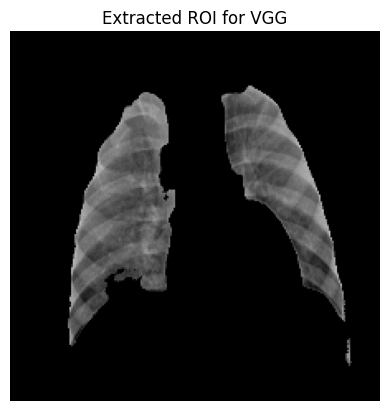

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_roi_from_mask(original_image, predicted_mask_binary, target_size=(224, 224)):
    # Ensure binary mask is scaled to match 8-bit image intensity (0-255)
    if predicted_mask_binary.max() <= 1:
        predicted_mask_binary = (predicted_mask_binary * 255).astype(np.uint8)

    # Resize the original image to match the mask dimensions if they differ
    if original_image.shape != predicted_mask_binary.shape:
        original_image = cv2.resize(original_image, (predicted_mask_binary.shape[1], predicted_mask_binary.shape[0]))

    # Apply the binary mask to the original image
    roi = cv2.bitwise_and(original_image, original_image, mask=predicted_mask_binary)

    # Resize ROI to VGG input size (224, 224)
    roi_resized = cv2.resize(roi, target_size)

    # Convert to 3-channel format for VGG input
    roi_resized_3ch = np.stack([roi_resized] * 3, axis=-1)

    return roi_resized_3ch

# Example usage
roi_image = extract_roi_from_mask(original_image, predicted_mask_binary[0, :, :, 0])

# Display the ROI image
plt.imshow(roi_image)
plt.title("Extracted ROI for VGG")
plt.axis('off')
plt.show()

In [9]:
import os
import numpy as np
import cv2
import gc
import tensorflow as tf

# Define paths
input_dir = "/content/dataset"
output_dir = "/content/roi_dataset"

# Create output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
class_dirs = ["Pneumonia-Viral","Normal","Pneumonia-Bacterial"]
for cls in class_dirs:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Function to load and preprocess the image
def load_and_preprocess_image(image_path, image_size=(512, 512)):
    img = cv2.imread(image_path)  # Load as RGB
    img_resized = cv2.resize(img, image_size) / 255.0  # Resize to match the model input
    return img_resized  # Return the resized image without wavelet transformation

# Function to batch-process images and save segmentation masks as ROIs
def process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=1):
    images = [img for img in os.listdir(input_class_dir) if os.path.isfile(os.path.join(input_class_dir, img))]
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)

    for batch_num in range(num_batches):
        batch_images = images[batch_num * batch_size: (batch_num + 1) * batch_size]
        original_images = []
        preprocessed_images = []

        # Load and preprocess batch images
        for img_name in batch_images:
            img_path = os.path.join(input_class_dir, img_name)
            original_image = load_and_preprocess_image(img_path)
            original_images.append(original_image)
            preprocessed_images.append(original_image)  # Use the same resized image for prediction

        # Convert batch to numpy array for prediction
        preprocessed_image_batch = np.array(preprocessed_images)

        # Predict the masks
        predicted_masks = model.predict(preprocessed_image_batch)
        predicted_masks_binary = (predicted_masks > 0.5).astype(np.uint8)

        # Process each mask in the batch and save ROI
        for i, img_name in enumerate(batch_images):
            # Only process if the mask has ROI
            if np.max(predicted_masks_binary[i]) == 0:
                print(f"No ROI detected for {img_name}. Skipping...")
                continue

            # Resize the predicted mask to match the original image size
            original_image_shape = original_images[i].shape[:2]
            predicted_mask_resized = cv2.resize(predicted_masks_binary[i, :, :, 0], (original_image_shape[1], original_image_shape[0]))

            # Extract ROI
            roi_image = original_images[i] * predicted_mask_resized[:, :, np.newaxis]  # Expand dimensions of the mask
            roi_image_uint8 = (roi_image * 255).astype(np.uint8)

            # Save the ROI image
            output_path = os.path.join(output_class_dir, img_name)
            cv2.imwrite(output_path, roi_image_uint8)
            print(f"Saved ROI to: {output_path}")

        # Free memory after each batch
        del original_images, preprocessed_images, preprocessed_image_batch, predicted_masks, predicted_masks_binary
        gc.collect()

# Run the function for each class directory
for cls in class_dirs:
    input_class_dir = os.path.join(input_dir, cls)
    output_class_dir = os.path.join(output_dir, cls)
    process_images_in_batches(input_class_dir, output_class_dir, model, batch_size=16)
    #tf.keras.backend.clear_session()

print("ROI extraction and saving complete!")

Streaming output truncated to the last 5000 lines.
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (747).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (464).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (1230).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (81).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (554).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (116).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (604).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (903).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (1264).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (892).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Viral (740).jpg
Saved ROI to: /content/roi_dataset/Pneumonia-Viral/Pneumonia-Vi

In [22]:
import shutil

folder_to_delete = "/content/split_roi_dataset"  # Replace with the actual folder name

try:
    shutil.rmtree(folder_to_delete)
    print(f"Folder '{folder_to_delete}' deleted successfully.")
except FileNotFoundError:
    print(f"Folder '{folder_to_delete}' not found.")
except OSError as e:
    print(f"Error deleting folder '{folder_to_delete}': {e}")

Folder '/content/split_roi_dataset' deleted successfully.


In [ ]:
# !zip -r /content/NormalUnet_roi_dataset.zip /content/roi_dataset
# from google.colab import files
# files.download("/content/NormalUnet_roi_dataset.zip")

In [12]:
import os
import tensorflow as tf

# Clear session and reset the default graph
tf.keras.backend.clear_session()

# Clear the runtime
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

vgg16 Model

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 model without the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in vgg_base.layers:
    layer.trainable = False

# Build top classifier
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Adjust output units based on number of classes

# Define the new model
model = Model(inputs=vgg_base.input, outputs=output)

In [24]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Test Train Val Split 80 10 10

In [25]:
import os
import shutil
import random

# Define paths
roi_dir = "/content/roi_dataset"  # Original ROI dataset directory
output_base_dir = "/content/split_roi_dataset"  # Output directory for split data

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Ensure output directories exist
splits = ['train', 'val', 'test']
class_dirs = ["Normal", "Pneumonia-Viral", "Pneumonia-Bacterial"]

for split in splits:
    for cls in class_dirs:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

# Split and move files
for cls in class_dirs:
    class_path = os.path.join(roi_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    # Calculate split indices
    train_count = int(train_ratio * len(images))
    val_count = int(val_ratio * len(images))

    # Assign images to each set
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Move images to respective directories
    for img_list, split in zip([train_images, val_images, test_images], splits):
        for img_name in img_list:
            src = os.path.join(class_path, img_name)
            dest = os.path.join(output_base_dir, split, cls, img_name)
            shutil.copy2(src, dest)  # Copy file to new split folder

    print(f"Completed split for class '{cls}'")

print("Dataset split complete!")

Completed split for class 'Normal'
Completed split for class 'Pneumonia-Viral'
Completed split for class 'Pneumonia-Bacterial'
Dataset split complete!


In [26]:
# prompt: code to check the number of images in a folder

import os

def count_images_in_folder(folder_path):
  """Counts the number of image files in a given folder.

  Args:
    folder_path: The path to the folder containing the images.

  Returns:
    The number of image files in the folder.
  """
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(image_extensions):
      image_count += 1
  return image_count

folder_path = "/content/split_roi_dataset/test/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/train/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/val/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/roi_dataset/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

The number of images in '/content/split_roi_dataset/test/Normal' is: 167
The number of images in '/content/split_roi_dataset/train/Normal' is: 1324
The number of images in '/content/split_roi_dataset/val/Normal' is: 165
The number of images in '/content/roi_dataset/Normal' is: 1656


Training on Dataset

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Path to your ROI dataset
train_dir = '/content/split_roi_dataset/train'
val_dir = '/content/split_roi_dataset/val'
test_dir = '/content/split_roi_dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3966 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),  # Stop if val_loss doesn't improve
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),  # Save the best model
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)  # Reduce learning rate if loss plateaus
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=callbacks
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 445ms/step - accuracy: 0.7380 - loss: 0.6045 - val_accuracy: 0.6958 - val_loss: 0.6023 - learning_rate: 2.5000e-05
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8438 - loss: 0.5597 - val_accuracy: 0.5000 - val_loss: 0.7473 - learning_rate: 2.5000e-05
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 445ms/step - accuracy: 0.7446 - loss: 0.5962 - val_accuracy: 0.6896 - val_loss: 0.5896 - learning_rate: 2.5000e-05
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.8438 - loss: 0.4678 - val_accuracy: 0.4286 - val_loss: 1.2867 - learning_rate: 2.5000e-05
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 439ms/step - accuracy: 0.7170 - loss: 0.6200 - val_accuracy: 0.6958 - val_loss: 0.6023 - learning_rate: 2.5000e-05
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6562 - loss: 0.5669 - val_accuracy: 0.7143 - val_loss: 0.4861 - learning_rate: 2.5000e-05
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 4

Testing Metrics

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 884ms/step - accuracy: 0.7409 - loss: 0.5532
Test accuracy: 73.75%


In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
test_generator.reset()  # Reset test generator if previously used in model.fit
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step


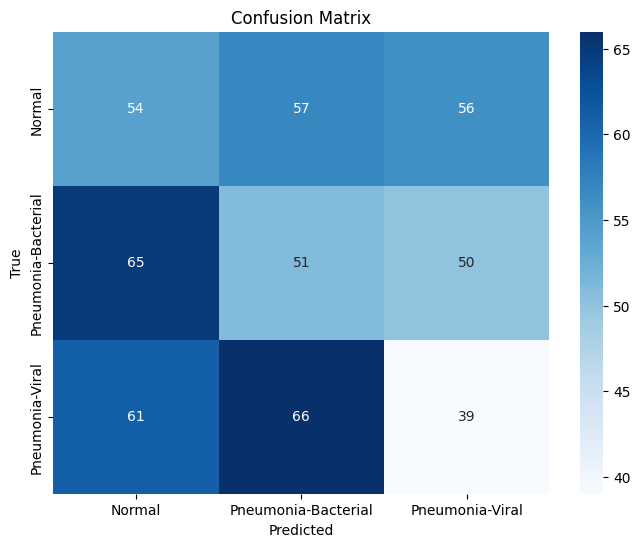

In [32]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [33]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                     precision    recall  f1-score   support

             Normal       0.30      0.32      0.31       167
Pneumonia-Bacterial       0.29      0.31      0.30       166
    Pneumonia-Viral       0.27      0.23      0.25       166

           accuracy                           0.29       499
          macro avg       0.29      0.29      0.29       499
       weighted avg       0.29      0.29      0.29       499

